### Import block

In [2]:
import os
import pandas as pd
import datetime as dt
import numpy as np
import altair as alt
import geopy.distance as gpx
import geopandas as gpd
from scipy.sparse import coo_matrix
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf

%matplotlib inline

### Function definitions

In [3]:
def one_hot_stack(px_combined,
                 centroid_lat = 0,
                 centroid_lon = 0,
                 centroid_date = dt.datetime.strptime('2017/01/01','%Y/%m/%d'),
                 span = 100,
                 days_back = 10,
                 days_forward = 5):
    
    min_date = centroid_date - dt.timedelta(days = days_back)
    max_date = centroid_date + dt.timedelta(days = days_forward)

    # Calculate location if we move 375 meters North and use to get grid steps.
    lat_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=0).latitude
    lat_step = abs(centroid_lat - lat_375)

    # Calculate location if we move 375 meters East and use to get grid steps.
    lon_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=90).longitude
    lon_step = abs(centroid_lon - lon_375)

    # Get bounding box of centroid and 100 pixels in all directions.
    min_lat = centroid_lat - (lat_step * span + 1)
    max_lat = centroid_lat + (lat_step * span)
    min_lon = centroid_lon - (lon_step * span + 1)
    max_lon = centroid_lon + (lon_step * span)

    # Filter data down to the range we want to plot
    t_df = px_combined[(px_combined['Date'] >= min_date) & (px_combined['Date'] <= max_date)]
    t_df = t_df[(t_df['Lat'] >= min_lat) & (t_df['Lat'] <= max_lat) & (t_df['Lon'] >= min_lon) & (t_df['Lon'] <= max_lon)]

    # Calculate pixel locations in the new grid.
    t_df['delta_lat'] = t_df['Lat'] - centroid_lat
    t_df['delta_lon'] = t_df['Lon'] - centroid_lon
    t_df['lat_grid'] = t_df['delta_lat'] // lat_step
    t_df['lon_grid'] = t_df['delta_lon'] // lon_step

    # Express date difference
    t_df['delta_day'] = (t_df['Date'] - centroid_date).dt.days
    
    # Convert grids to not have negative locations.
    t_df['lat_grid'] = t_df['lat_grid'] + span
    t_df['lon_grid'] = t_df['lon_grid'] + span
    
    # Build an array for each day in our date range then stack them. One for the inputs and one for the outputs.
    input_stack = []
    for x in range(-days_back, 1):
        s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
        if len(s_df) > 0:
            cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
            cm = np.pad(cm, pad_width=((0, (2 * span) - cm.shape[0]),(0,(2 * span) - cm.shape[1])), mode = 'constant')
        else:
            cm = np.zeros(((2 * span),(2 * span)))
        input_stack.append(cm)
    input_stack = np.stack(input_stack)

    output_stack = []
    for x in range(1, days_forward + 1): 
        s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
        if len(s_df) > 0:
            cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
            cm = np.pad(cm, pad_width=((0, (2 * span) - cm.shape[0]),(0,(2 * span) - cm.shape[1])), mode = 'constant')
        else:
            cm = np.zeros(((2 * span),(2 * span)))
        output_stack.append(cm)
    output_stack = np.stack(output_stack)
    
    return input_stack, output_stack

In [4]:
def feature_stack(px_combined,
                 centroid_lat = 0,
                 centroid_lon = 0,
                 centroid_date = dt.datetime.strptime('2017/01/01','%Y/%m/%d'),
                 span = 100,
                 days_back = 10,
                 days_forward = 5):
    
    min_date = centroid_date - dt.timedelta(days = days_back)
    max_date = centroid_date + dt.timedelta(days = days_forward)

    # Calculate location if we move 375 meters North and use to get grid steps.
    lat_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=0).latitude
    lat_step = abs(centroid_lat - lat_375)

    # Calculate location if we move 375 meters East and use to get grid steps.
    lon_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=90).longitude
    lon_step = abs(centroid_lon - lon_375)

    # Get bounding box of centroid and 100 pixels in all directions.
    min_lat = centroid_lat - (lat_step * span + 1)
    max_lat = centroid_lat + (lat_step * span)
    min_lon = centroid_lon - (lon_step * span + 1)
    max_lon = centroid_lon + (lon_step * span)

    # Filter data down to the range we want to plot
    t_df = px_combined[(px_combined['Date'] >= min_date) & (px_combined['Date'] <= max_date)]
    t_df = t_df[(t_df['Lat'] >= min_lat) & (t_df['Lat'] <= max_lat) & (t_df['Lon'] >= min_lon) & (t_df['Lon'] <= max_lon)]

    # Calculate pixel locations in the new grid.
    t_df['delta_lat'] = t_df['Lat'] - centroid_lat
    t_df['delta_lon'] = t_df['Lon'] - centroid_lon
    t_df['lat_grid'] = t_df['delta_lat'] // lat_step
    t_df['lon_grid'] = t_df['delta_lon'] // lon_step

    # Express date difference
    t_df['delta_day'] = (t_df['Date'] - centroid_date).dt.days
    
    # Convert grids to not have negative locations.
    t_df['lat_grid'] = t_df['lat_grid'] + span
    t_df['lon_grid'] = t_df['lon_grid'] + span
    
    # Build an array for each day in our date range then stack them. One for the inputs and one for the outputs.
    input_stack = []
    for x in range(-days_back, 1):
        s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
        if len(s_df) > 0:
            cm1 = coo_matrix((s_df['T4'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
            cm1 = np.pad(cm1, pad_width=((0, 201 - cm1.shape[0]),(0,(2 * span) - cm1.shape[1])), mode = 'constant')
            cm2 = coo_matrix((s_df['T5'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
            cm2 = np.pad(cm2, pad_width=((0, 201 - cm2.shape[0]),(0,(2 * span) - cm2.shape[1])), mode = 'constant')
            cm3 = coo_matrix((s_df['FRP'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
            cm3 = np.pad(cm3, pad_width=((0, 201 - cm3.shape[0]),(0,(2 * span) - cm3.shape[1])), mode = 'constant')
            cm4 = coo_matrix((s_df['Rad13'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
            cm4 = np.pad(cm4, pad_width=((0, 201 - cm4.shape[0]),(0,(2 * span) - cm4.shape[1])), mode = 'constant')
        else:
            cm1 = np.zeros(((2 * span),(2 * span)))
            cm2 = np.zeros(((2 * span),(2 * span)))
            cm3 = np.zeros(((2 * span),(2 * span)))
            cm4 = np.zeros(((2 * span),(2 * span)))
        input_stack.append(np.stack([cm1, cm2, cm3, cm4]))
    input_stack = np.stack(input_stack)

    output_stack = []
    for x in range(1, days_forward + 1):
        s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
        if len(s_df) > 0:
            cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
            cm = np.pad(cm, pad_width=((0, (2 * span) - cm.shape[0]),(0,(2 * span) - cm.shape[1])), mode = 'constant')
        else:
            cm = np.zeros(((2 * span),(2 * span)))
        output_stack.append(cm)
    output_stack = np.stack(output_stack)
    
    return input_stack, output_stack

In [5]:
def one_hot_with_defo_stack(px_combined,
                            defo_gpd,
                            centroid_lat = 0,
                            centroid_lon = 0,
                            centroid_date = dt.datetime.strptime('2017/01/01','%Y/%m/%d'),
                            span = 15,
                            days_back = 9,
                            days_forward = 10):
    
    min_date = centroid_date - dt.timedelta(days = days_back)
    max_date = centroid_date + dt.timedelta(days = days_forward)

    # Calculate location if we move 375 meters North and use to get grid steps.
    lat_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=0).latitude
    lat_step = abs(centroid_lat - lat_375)

    # Calculate location if we move 375 meters East and use to get grid steps.
    lon_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=90).longitude
    lon_step = abs(centroid_lon - lon_375)

    # Get bounding box of centroid and span pixels in all directions.
    min_lat = centroid_lat - (lat_step * (span + 1))
    max_lat = centroid_lat + (lat_step * span)
    min_lon = centroid_lon - (lon_step * (span + 1))
    max_lon = centroid_lon + (lon_step * span)

    # Filter data down to the range we want to plot
    t_df = px_combined[(px_combined['Date'] >= min_date) & (px_combined['Date'] <= max_date)]
    t_df = t_df[(t_df['Lat'] >= min_lat) & (t_df['Lat'] <= max_lat) & (t_df['Lon'] >= min_lon) & (t_df['Lon'] <= max_lon)]

    # Calculate pixel locations in the new grid.
    t_df['delta_lat'] = t_df['Lat'] - centroid_lat
    t_df['delta_lon'] = t_df['Lon'] - centroid_lon
    t_df['lat_grid'] = t_df['delta_lat'] // lat_step
    t_df['lon_grid'] = t_df['delta_lon'] // lon_step

    # Express date difference
    t_df['delta_day'] = (t_df['Date'] - centroid_date).dt.days

    # Convert grids to not have negative locations.
    t_df['lat_grid'] = t_df['lat_grid'] + span + 1
    t_df['lon_grid'] = t_df['lon_grid'] + span + 1

    ### Begin added code for deforestation processing.

    # Limit deforestation polygons to those that intersect with centroid grid.
    centroid_defo = defo_gpd[(defo_gpd['x_min'] >= min_lon) & (defo_gpd['x_max'] <= max_lon) &
                   (defo_gpd['y_min'] >= min_lat) & (defo_gpd['y_max'] <= max_lat) &
                   (defo_gpd['x_min'] + defo_gpd['x_min'] + defo_gpd['x_min'] + defo_gpd['x_min'] != 0) &
                   (defo_gpd['Date'] <= min_date)]

    if len(centroid_defo) > 0:
        # Build grid.
        lats = [min_lat + lat_step * x for x in range(0,span * 2 + 2)]
        lons = [min_lon + lon_step * x for x in range(0,span * 2 + 2)]
        cs = [c for c in range(0,span * 2 + 2)]
        grid = list(itertools.product(lons, lats))
        grid_xy = list(itertools.product(cs, cs))
        grid_points = gpd.points_from_xy([x[0] for x in grid], [y[1] for y in grid])
        grid_gdf = gpd.GeoDataFrame(grid_points)
        grid_gdf.rename(mapper={0:'geometry'}, axis=1, inplace = True)
        grid_gdf['x'] = [c[0] for c in grid_xy]
        grid_gdf['y'] = [c[1] for c in grid_xy]
        grid_gdf = grid_gdf.set_geometry('geometry')
        grid_gdf.crs = 'epsg:4674'

        # Calculate deforested gridpoints.
        grid_gdf['deforested'] = np.minimum(pd.concat(
            [grid_gdf.within(centroid_defo.iloc[x].geometry.buffer(0)) for x in range(0,len(centroid_defo))]
            , axis=1).sum(1),1)

        # Convert to numpy format.
        dm = coo_matrix((grid_gdf['deforested'],(grid_gdf['x'].astype(int),grid_gdf['y'].astype(int)))).toarray()
    else:
        dm = np.zeros(((2 * span + 2),(2 * span + 2)))

    ### End added code for deforestaion processing.

    # Build an array for each day in our date range then stack them. One for the inputs and one for the outputs.
    input_stack = []
    for x in range(-days_back, 1):
        s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
        if len(s_df) > 0:
            cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
            cm = np.pad(cm, pad_width=((0, (2 * span + 2) - cm.shape[0]),(0,(2 * span + 2) - cm.shape[1])), mode = 'constant')
        else:
            cm = np.zeros(((2 * span + 2),(2 * span + 2)))
        input_stack.append(np.stack([cm, dm])) # All deforestation frames (dm) remain constant.
    input_stack = np.stack(input_stack)

    output_stack = []
    for x in range(1, days_forward + 1):
        s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
        if len(s_df) > 0:
            cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
            cm = np.pad(cm, pad_width=((0, (2 * span + 2) - cm.shape[0]),(0,(2 * span + 2) - cm.shape[1])), mode = 'constant')
        else:
            cm = np.zeros(((2 * span + 2),(2 * span + 2)))
        output_stack.append(np.stack(cm)) # All deforestation frames (dm) remain constant.
    output_stack = np.stack(output_stack)
        
        
    return input_stack, output_stack

In [6]:
def one_hot_with_defo_wind_stack(px_combined,
                            defo_gpd,
                            wind_df,
                            centroid_lat = 0,
                            centroid_lon = 0,
                            centroid_date = dt.datetime.strptime('2017/01/01','%Y/%m/%d'),
                            span = 15,
                            days_back = 9,
                            days_forward = 10):
    
    min_date = centroid_date - dt.timedelta(days = days_back)
    max_date = centroid_date + dt.timedelta(days = days_forward)

    # Calculate location if we move 375 meters North and use to get grid steps.
    lat_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=0).latitude
    lat_step = abs(centroid_lat - lat_375)

    # Calculate location if we move 375 meters East and use to get grid steps.
    lon_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=90).longitude
    lon_step = abs(centroid_lon - lon_375)

    # Get bounding box of centroid and span pixels in all directions.
    min_lat = centroid_lat - (lat_step * (span + 1))
    max_lat = centroid_lat + (lat_step * span)
    min_lon = centroid_lon - (lon_step * (span + 1))
    max_lon = centroid_lon + (lon_step * span)

    # Filter data down to the range we want to plot
    t_df = px_combined[(px_combined['Date'] >= min_date) & (px_combined['Date'] <= max_date)]
    t_df = t_df[(t_df['Lat'] >= min_lat) & (t_df['Lat'] <= max_lat) & (t_df['Lon'] >= min_lon) & (t_df['Lon'] <= max_lon)]

    # Calculate pixel locations in the new grid.
    t_df['delta_lat'] = t_df['Lat'] - centroid_lat
    t_df['delta_lon'] = t_df['Lon'] - centroid_lon
    t_df['lat_grid'] = t_df['delta_lat'] // lat_step
    t_df['lon_grid'] = t_df['delta_lon'] // lon_step

    # Express date difference
    t_df['delta_day'] = (t_df['Date'] - centroid_date).dt.days

    # Convert grids to not have negative locations.
    t_df['lat_grid'] = t_df['lat_grid'] + span + 1
    t_df['lon_grid'] = t_df['lon_grid'] + span + 1

    ### Begin added code for deforestation processing.

    # Limit deforestation polygons to those that intersect with centroid grid.
    centroid_defo = defo_gpd[(defo_gpd['x_min'] >= min_lon) & (defo_gpd['x_max'] <= max_lon) &
                   (defo_gpd['y_min'] >= min_lat) & (defo_gpd['y_max'] <= max_lat) &
                   (defo_gpd['x_min'] + defo_gpd['x_min'] + defo_gpd['x_min'] + defo_gpd['x_min'] != 0) &
                   (defo_gpd['Date'] <= min_date)]

    if len(centroid_defo) > 0:
        # Build grid.
        lats = [min_lat + lat_step * x for x in range(0,span * 2 + 2)]
        lons = [min_lon + lon_step * x for x in range(0,span * 2 + 2)]
        cs = [c for c in range(0,span * 2 + 2)]
        grid = list(itertools.product(lons, lats))
        grid_xy = list(itertools.product(cs, cs))
        grid_points = gpd.points_from_xy([x[0] for x in grid], [y[1] for y in grid])
        grid_gdf = gpd.GeoDataFrame(grid_points)
        grid_gdf.rename(mapper={0:'geometry'}, axis=1, inplace = True)
        grid_gdf['x'] = [c[0] for c in grid_xy]
        grid_gdf['y'] = [c[1] for c in grid_xy]
        grid_gdf = grid_gdf.set_geometry('geometry')
        grid_gdf.crs = 'epsg:4674'

        # Calculate deforested gridpoints.
        grid_gdf['deforested'] = np.minimum(pd.concat(
            [grid_gdf.within(centroid_defo.iloc[x].geometry.buffer(0)) for x in range(0,len(centroid_defo))]
            , axis=1).sum(1),1)

        # Convert to numpy format.
        dm = coo_matrix((grid_gdf['deforested'],(grid_gdf['x'].astype(int),grid_gdf['y'].astype(int)))).toarray()
    else:
        dm = np.zeros(((2 * span + 2),(2 * span + 2)))

    ### End added code for deforestaion processing.
    
    ### Begin added code for wind processing.
    wu, wv = [], []
    for x in range(-days_back, 1):
        t_date = (centroid_date + dt.timedelta(days = x)).date()
        (u1,v1) = wdf_grouped.loc[t_date, w_lat_min, w_lon_min] 
        (u2,v2) = wdf_grouped.loc[t_date, w_lat_max, w_lon_min] 
        (u3,v3) = wdf_grouped.loc[t_date, w_lat_min, w_lon_max] 
        (u4,v4) = wdf_grouped.loc[t_date, w_lat_max, w_lon_max]
        u = sum([u1, u2, u3, u4])
        v = sum([v1, v2, v3, v4])
        
        wu.append(np.full((2 * span + 2, 2 * span + 2),u))
        wv.append(np.full((2 * span + 2, 2 * span + 2),v))
    wu = np.stack(wu)
    wv = np.stack(wv)
    ### End added code for wind processing.

    # Build an array for each day in our date range then stack them. One for the inputs and one for the outputs.
    input_stack = []
    for x in range(-days_back, 1):
        s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
        if len(s_df) > 0:
            cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
            cm = np.pad(cm, pad_width=((0, (2 * span + 2) - cm.shape[0]),(0,(2 * span + 2) - cm.shape[1])), mode = 'constant')
        else:
            cm = np.zeros(((2 * span + 2),(2 * span + 2)))
        input_stack.append(cm)
    # New stack logic where we layer fires/defo/wind-U/wind-V and fixed channel ordering.
    input_stack = np.stack([np.stack(input_stack), np.stack([dm]*10), wu, wv], axis = -1)

    output_stack = []
    for x in range(1, days_forward + 1):
        s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
        if len(s_df) > 0:
            cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
            cm = np.pad(cm, pad_width=((0, (2 * span + 2) - cm.shape[0]),(0,(2 * span + 2) - cm.shape[1])), mode = 'constant')
        else:
            cm = np.zeros(((2 * span + 2),(2 * span + 2)))
        output_stack.append(np.stack(cm))
    output_stack = np.stack(output_stack)
        
        
    return input_stack, output_stack

In [7]:
def one_hot_stack_and_save(
                 centroid_df,
                 px_combined,
                 meta_folder = '/data/',
                 feature_folder = '/data/features/',
                 label_folder = '/data/labels/',
                 span = 100,
                 days_back = 10,
                 days_forward = 5):
    
    meta_df = centroid_df.copy()
    meta_df['features'] = feature_folder + meta_df.index.astype(str) + '.npy'
    meta_df['labels'] = label_folder + meta_df.index.astype(str) + '.npy'
    
    for x in range(0,len(centroid_df)):
        
        t_index = centroid_df.index[x].astype(str)
        centroid_lat = centroid_df.iloc[x].Lat
        centroid_lon = centroid_df.iloc[x].Lon
        centroid_date = centroid_df.iloc[x].Date
        
        min_date = centroid_date - dt.timedelta(days = days_back)
        max_date = centroid_date + dt.timedelta(days = days_forward)

        # Calculate location if we move 375 meters North and use to get grid steps.
        lat_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=0).latitude
        lat_step = abs(centroid_lat - lat_375)

        # Calculate location if we move 375 meters East and use to get grid steps.
        lon_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=90).longitude
        lon_step = abs(centroid_lon - lon_375)

        # Get bounding box of centroid and 100 pixels in all directions.
        min_lat = centroid_lat - (lat_step * span + 1)
        max_lat = centroid_lat + (lat_step * span)
        min_lon = centroid_lon - (lon_step * span + 1)
        max_lon = centroid_lon + (lon_step * span)

        # Filter data down to the range we want to plot
        t_df = px_combined[(px_combined['Date'] >= min_date) & (px_combined['Date'] <= max_date)]
        t_df = t_df[(t_df['Lat'] >= min_lat) & (t_df['Lat'] <= max_lat) & (t_df['Lon'] >= min_lon) & (t_df['Lon'] <= max_lon)]

        # Calculate pixel locations in the new grid.
        t_df['delta_lat'] = t_df['Lat'] - centroid_lat
        t_df['delta_lon'] = t_df['Lon'] - centroid_lon
        t_df['lat_grid'] = t_df['delta_lat'] // lat_step
        t_df['lon_grid'] = t_df['delta_lon'] // lon_step

        # Express date difference
        t_df['delta_day'] = (t_df['Date'] - centroid_date).dt.days

        # Convert grids to not have negative locations.
        t_df['lat_grid'] = t_df['lat_grid'] + span
        t_df['lon_grid'] = t_df['lon_grid'] + span

        # Build an array for each day in our date range then stack them. One for the inputs and one for the outputs.
        input_stack = []
        for x in range(-days_back, 1):
            s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
            if len(s_df) > 0:
                cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
                cm = np.pad(cm, pad_width=((0, (2 * span) - cm.shape[0]),(0,(2 * span) - cm.shape[1])), mode = 'constant')
            else:
                cm = np.zeros(((2 * span),(2 * span)))
            input_stack.append(cm)
        input_stack = np.stack(input_stack)

        output_stack = []
        for x in range(1, days_forward + 1):
            s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
            if len(s_df) > 0:
                cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
                cm = np.pad(cm, pad_width=((0, (2 * span) - cm.shape[0]),(0,(2 * span) - cm.shape[1])), mode = 'constant')
            else:
                cm = np.zeros(((2 * span),(2 * span)))
            output_stack.append(cm)
        output_stack = np.stack(output_stack)
        
        # Save to disk
        np.save(feature_folder + t_index + '.npy', input_stack)
        np.save(label_folder + t_index + '.npy', output_stack)
        
    meta_df.to_csv(meta_folder + 'meta.csv')

In [8]:
def feature_stack_and_save(
                 centroid_df,
                 px_combined,
                 meta_folder = '/data/',
                 feature_folder = '/data/features/',
                 label_folder = '/data/labels/',
                 span = 100,
                 days_back = 10,
                 days_forward = 5):
    
    meta_df = centroid_df.copy()
    meta_df['features'] = feature_folder + meta_df.index.astype(str) + '.npy'
    meta_df['labels'] = label_folder + meta_df.index.astype(str) + '.npy'
    
    for x in range(0,len(centroid_df)):
        
        t_index = centroid_df.index[x].astype(str)
        centroid_lat = centroid_df.iloc[x].Lat
        centroid_lon = centroid_df.iloc[x].Lon
        centroid_date = centroid_df.iloc[x].Date
        
        min_date = centroid_date - dt.timedelta(days = days_back)
        max_date = centroid_date + dt.timedelta(days = days_forward)

        # Calculate location if we move 375 meters North and use to get grid steps.
        lat_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=0).latitude
        lat_step = abs(centroid_lat - lat_375)

        # Calculate location if we move 375 meters East and use to get grid steps.
        lon_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=90).longitude
        lon_step = abs(centroid_lon - lon_375)

        # Get bounding box of centroid and 100 pixels in all directions.
        min_lat = centroid_lat - (lat_step * span + 1)
        max_lat = centroid_lat + (lat_step * span)
        min_lon = centroid_lon - (lon_step * span + 1)
        max_lon = centroid_lon + (lon_step * span)

        # Filter data down to the range we want to plot
        t_df = px_combined[(px_combined['Date'] >= min_date) & (px_combined['Date'] <= max_date)]
        t_df = t_df[(t_df['Lat'] >= min_lat) & (t_df['Lat'] <= max_lat) & (t_df['Lon'] >= min_lon) & (t_df['Lon'] <= max_lon)]

        # Calculate pixel locations in the new grid.
        t_df['delta_lat'] = t_df['Lat'] - centroid_lat
        t_df['delta_lon'] = t_df['Lon'] - centroid_lon
        t_df['lat_grid'] = t_df['delta_lat'] // lat_step
        t_df['lon_grid'] = t_df['delta_lon'] // lon_step

        # Express date difference
        t_df['delta_day'] = (t_df['Date'] - centroid_date).dt.days

        # Convert grids to not have negative locations.
        t_df['lat_grid'] = t_df['lat_grid'] + span
        t_df['lon_grid'] = t_df['lon_grid'] + span

        # Build an array for each day in our date range then stack them. One for the inputs and one for the outputs.
        input_stack = []
        for x in range(-days_back, 1):
            s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
            if len(s_df) > 0:
                cm1 = coo_matrix((s_df['T4'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
                cm1 = np.pad(cm1, pad_width=((0, (2 * span) - cm1.shape[0]),(0,(2 * span) - cm1.shape[1])), mode = 'constant')
                cm2 = coo_matrix((s_df['T5'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
                cm2 = np.pad(cm2, pad_width=((0, (2 * span) - cm2.shape[0]),(0,(2 * span) - cm2.shape[1])), mode = 'constant')
                cm3 = coo_matrix((s_df['FRP'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
                cm3 = np.pad(cm3, pad_width=((0, (2 * span) - cm3.shape[0]),(0,(2 * span) - cm3.shape[1])), mode = 'constant')
                cm4 = coo_matrix((s_df['Rad13'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
                cm4 = np.pad(cm4, pad_width=((0, (2 * span) - cm4.shape[0]),(0,(2 * span) - cm4.shape[1])), mode = 'constant')
            else:
                cm1 = np.zeros(((2 * span),(2 * span)))
                cm2 = np.zeros(((2 * span),(2 * span)))
                cm3 = np.zeros(((2 * span),(2 * span)))
                cm4 = np.zeros(((2 * span),(2 * span)))
            input_stack.append(np.stack([cm1, cm2, cm3, cm4]))
        input_stack = np.stack(input_stack)

        output_stack = []
        for x in range(1, days_forward + 1):
            s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
            if len(s_df) > 0:
                cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
                cm = np.pad(cm, pad_width=((0, (2 * span) - cm.shape[0]),(0,(2 * span) - cm.shape[1])), mode = 'constant')
            else:
                cm = np.zeros(((2 * span),(2 * span)))
            output_stack.append(cm)
        output_stack = np.stack(output_stack)
        
        
        
        # Save to disk
        np.save(feature_folder + t_index + '.npy', input_stack)
        np.save(label_folder + t_index + '.npy', output_stack)
        
    meta_df.to_csv(meta_folder + 'meta.csv')

In [9]:
def one_hot_with_defo_stack_and_save(
                 centroid_df,
                 defo_gpd,
                 px_combined,
                 meta_folder = '/data/',
                 feature_folder = '/data/features/',
                 label_folder = '/data/labels/',
                 span = 15,
                 days_back = 10,
                 days_forward = 10):
    
    meta_df = centroid_df.copy()
    meta_df['features'] = feature_folder + meta_df.index.astype(str) + '.npy'
    meta_df['labels'] = label_folder + meta_df.index.astype(str) + '.npy'
    
    for x in range(0,len(centroid_df)):
        
        t_index = centroid_df.index[x].astype(str)
        centroid_lat = centroid_df.iloc[x].Lat
        centroid_lon = centroid_df.iloc[x].Lon
        centroid_date = centroid_df.iloc[x].Date
        
        min_date = centroid_date - dt.timedelta(days = days_back)
        max_date = centroid_date + dt.timedelta(days = days_forward)

        # Calculate location if we move 375 meters North and use to get grid steps.
        lat_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=0).latitude
        lat_step = abs(centroid_lat - lat_375)

        # Calculate location if we move 375 meters East and use to get grid steps.
        lon_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=90).longitude
        lon_step = abs(centroid_lon - lon_375)

        # Get bounding box of centroid and span pixels in all directions.
        min_lat = centroid_lat - (lat_step * (span + 1))
        max_lat = centroid_lat + (lat_step * span)
        min_lon = centroid_lon - (lon_step * (span + 1))
        max_lon = centroid_lon + (lon_step * span)
        
        # Filter data down to the range we want to plot
        t_df = px_combined[(px_combined['Date'] >= min_date) & (px_combined['Date'] <= max_date)]
        t_df = t_df[(t_df['Lat'] >= min_lat) & (t_df['Lat'] <= max_lat) & (t_df['Lon'] >= min_lon) & (t_df['Lon'] <= max_lon)]

        # Calculate pixel locations in the new grid.
        t_df['delta_lat'] = t_df['Lat'] - centroid_lat
        t_df['delta_lon'] = t_df['Lon'] - centroid_lon
        t_df['lat_grid'] = t_df['delta_lat'] // lat_step
        t_df['lon_grid'] = t_df['delta_lon'] // lon_step

        # Express date difference
        t_df['delta_day'] = (t_df['Date'] - centroid_date).dt.days

        # Convert grids to not have negative locations.
        t_df['lat_grid'] = t_df['lat_grid'] + span + 1
        t_df['lon_grid'] = t_df['lon_grid'] + span + 1
        
        ### Begin added code for deforestation processing.
        
        # Limit deforestation polygons to those that intersect with centroid grid.
        centroid_defo = defo_gpd[(defo_gpd['x_min'] >= min_lon) & (defo_gpd['x_max'] <= max_lon) &
                       (defo_gpd['y_min'] >= min_lat) & (defo_gpd['y_max'] <= max_lat) &
                       (defo_gpd['x_min'] + defo_gpd['x_min'] + defo_gpd['x_min'] + defo_gpd['x_min'] != 0) &
                       (defo_gpd['Date'] <= min_date)]
        
        if len(centroid_defo) > 0:
            # Build grid.
            lats = [min_lat + lat_step * x for x in range(0,span * 2 + 2)]
            lons = [min_lon + lon_step * x for x in range(0,span * 2 + 2)]
            cs = [c for c in range(0,span * 2 + 2)]
            grid = list(itertools.product(lons, lats))
            grid_xy = list(itertools.product(cs, cs))
            grid_points = gpd.points_from_xy([x[0] for x in grid], [y[1] for y in grid])
            grid_gdf = gpd.GeoDataFrame(grid_points)
            grid_gdf.rename(mapper={0:'geometry'}, axis=1, inplace = True)
            grid_gdf['x'] = [c[0] for c in grid_xy]
            grid_gdf['y'] = [c[1] for c in grid_xy]
            grid_gdf = grid_gdf.set_geometry('geometry')
            grid_gdf.crs = 'epsg:4674'

            # Calculate deforested gridpoints.
            grid_gdf['deforested'] = np.minimum(pd.concat(
                [grid_gdf.within(centroid_defo.iloc[x].geometry.buffer(0)) for x in range(0,len(centroid_defo))]
                , axis=1).sum(1),1)

            # Convert to numpy format.
            dm = coo_matrix((grid_gdf['deforested'],(grid_gdf['x'].astype(int),grid_gdf['y'].astype(int)))).toarray()
        else:
            dm = np.zeros(((2 * span + 2),(2 * span + 2)))
        
        ### End added code for deforestaion processing.

        # Build an array for each day in our date range then stack them. One for the inputs and one for the outputs.
        input_stack = []
        for x in range(-days_back, 1):
            s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
            if len(s_df) > 0:
                cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
                cm = np.pad(cm, pad_width=((0, (2 * span + 2) - cm.shape[0]),(0,(2 * span + 2) - cm.shape[1])), mode = 'constant')
            else:
                cm = np.zeros(((2 * span + 2),(2 * span + 2)))
            input_stack.append([cm, dm]) # All deforestation frames (dm) remain constant.
        input_stack = np.stack(input_stack)

        output_stack = []
        for x in range(1, days_forward + 1):
            s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
            if len(s_df) > 0:
                cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
                cm = np.pad(cm, pad_width=((0, (2 * span + 2) - cm.shape[0]),(0,(2 * span + 2) - cm.shape[1])), mode = 'constant')
            else:
                cm = np.zeros(((2 * span + 2),(2 * span + 2)))
            output_stack.append(np.stack(cm))
        output_stack = np.stack(output_stack)
        
        ## Save to disk
        np.save(feature_folder + t_index + '.npy', input_stack)
        np.save(label_folder + t_index + '.npy', output_stack)
        
    meta_df.to_csv(meta_folder + 'meta.csv')

In [10]:
def one_hot_with_defo_wind_stack_and_save(
                 centroid_df,
                 defo_gpd,
                 wind_df,
                 px_combined,
                 meta_folder = '/data/',
                 feature_folder = '/data/features/',
                 label_folder = '/data/labels/',
                 span = 15,
                 days_back = 10,
                 days_forward = 10):
    
    meta_df = centroid_df.copy()
    meta_df['features'] = feature_folder + meta_df.index.astype(str) + '.npy'
    meta_df['labels'] = label_folder + meta_df.index.astype(str) + '.npy'
    
    for x in range(0,len(centroid_df)):
        
        t_index = centroid_df.index[x].astype(str)
        centroid_lat = centroid_df.iloc[x].Lat
        centroid_lon = centroid_df.iloc[x].Lon
        centroid_date = centroid_df.iloc[x].Date
        
        min_date = centroid_date - dt.timedelta(days = days_back)
        max_date = centroid_date + dt.timedelta(days = days_forward)

        # Calculate location if we move 375 meters North and use to get grid steps.
        lat_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=0).latitude
        lat_step = abs(centroid_lat - lat_375)

        # Calculate location if we move 375 meters East and use to get grid steps.
        lon_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=90).longitude
        lon_step = abs(centroid_lon - lon_375)

        # Get bounding box of centroid and span pixels in all directions.
        min_lat = centroid_lat - (lat_step * (span + 1))
        max_lat = centroid_lat + (lat_step * span)
        min_lon = centroid_lon - (lon_step * (span + 1))
        max_lon = centroid_lon + (lon_step * span)
        
        # Filter data down to the range we want to plot
        t_df = px_combined[(px_combined['Date'] >= min_date) & (px_combined['Date'] <= max_date)]
        t_df = t_df[(t_df['Lat'] >= min_lat) & (t_df['Lat'] <= max_lat) & (t_df['Lon'] >= min_lon) & (t_df['Lon'] <= max_lon)]

        # Calculate pixel locations in the new grid.
        t_df['delta_lat'] = t_df['Lat'] - centroid_lat
        t_df['delta_lon'] = t_df['Lon'] - centroid_lon
        t_df['lat_grid'] = t_df['delta_lat'] // lat_step
        t_df['lon_grid'] = t_df['delta_lon'] // lon_step

        # Express date difference
        t_df['delta_day'] = (t_df['Date'] - centroid_date).dt.days

        # Convert grids to not have negative locations.
        t_df['lat_grid'] = t_df['lat_grid'] + span + 1
        t_df['lon_grid'] = t_df['lon_grid'] + span + 1
        
        ### Begin added code for deforestation processing.
        
        # Limit deforestation polygons to those that intersect with centroid grid.
        centroid_defo = defo_gpd[(defo_gpd['x_min'] >= min_lon) & (defo_gpd['x_max'] <= max_lon) &
                       (defo_gpd['y_min'] >= min_lat) & (defo_gpd['y_max'] <= max_lat) &
                       (defo_gpd['x_min'] + defo_gpd['x_min'] + defo_gpd['x_min'] + defo_gpd['x_min'] != 0) &
                       (defo_gpd['Date'] <= min_date)]
        
        if len(centroid_defo) > 0:
            # Build grid.
            lats = [min_lat + lat_step * x for x in range(0,span * 2 + 2)]
            lons = [min_lon + lon_step * x for x in range(0,span * 2 + 2)]
            cs = [c for c in range(0,span * 2 + 2)]
            grid = list(itertools.product(lons, lats))
            grid_xy = list(itertools.product(cs, cs))
            grid_points = gpd.points_from_xy([x[0] for x in grid], [y[1] for y in grid])
            grid_gdf = gpd.GeoDataFrame(grid_points)
            grid_gdf.rename(mapper={0:'geometry'}, axis=1, inplace = True)
            grid_gdf['x'] = [c[0] for c in grid_xy]
            grid_gdf['y'] = [c[1] for c in grid_xy]
            grid_gdf = grid_gdf.set_geometry('geometry')
            grid_gdf.crs = 'epsg:4674'

            # Calculate deforested gridpoints.
            grid_gdf['deforested'] = np.minimum(pd.concat(
                [grid_gdf.within(centroid_defo.iloc[x].geometry.buffer(0)) for x in range(0,len(centroid_defo))]
                , axis=1).sum(1),1)

            # Convert to numpy format.
            dm = coo_matrix((grid_gdf['deforested'],(grid_gdf['x'].astype(int),grid_gdf['y'].astype(int)))).toarray()
        else:
            dm = np.zeros(((2 * span + 2),(2 * span + 2)))
        
        ### End added code for deforestaion processing.
        
        ### Begin added code for wind processing.
        wu, wv = [], []
        for x in range(-days_back, 1):
            t_date = (centroid_date + dt.timedelta(days = x)).date()
            (u1,v1) = wdf_grouped.loc[t_date, w_lat_min, w_lon_min] 
            (u2,v2) = wdf_grouped.loc[t_date, w_lat_max, w_lon_min] 
            (u3,v3) = wdf_grouped.loc[t_date, w_lat_min, w_lon_max] 
            (u4,v4) = wdf_grouped.loc[t_date, w_lat_max, w_lon_max]
            u = sum([u1, u2, u3, u4])
            v = sum([v1, v2, v3, v4])

            wu.append(np.full((2 * span + 2, 2 * span + 2),u))
            wv.append(np.full((2 * span + 2, 2 * span + 2),v))
        wu = np.stack(wu)
        wv = np.stack(wv)
        ### End added code for wind processing.

        # Build an array for each day in our date range then stack them. One for the inputs and one for the outputs.
        input_stack = []
        for x in range(-days_back, 1):
            s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
            if len(s_df) > 0:
                cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
                cm = np.pad(cm, pad_width=((0, (2 * span + 2) - cm.shape[0]),(0,(2 * span + 2) - cm.shape[1])), mode = 'constant')
            else:
                cm = np.zeros(((2 * span + 2),(2 * span + 2)))
            input_stack.append(cm)
        # New stack logic where we layer fires/defo/wind-U/wind-V and fixed channel ordering.
        input_stack = np.stack([np.stack(input_stack), np.stack([dm]*10), wu, wv], axis = -1)

        output_stack = []
        for x in range(1, days_forward + 1):
            s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
            if len(s_df) > 0:
                cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
                cm = np.pad(cm, pad_width=((0, (2 * span + 2) - cm.shape[0]),(0,(2 * span + 2) - cm.shape[1])), mode = 'constant')
            else:
                cm = np.zeros(((2 * span + 2),(2 * span + 2)))
            output_stack.append(np.stack(cm))
        output_stack = np.stack(output_stack)
        
        ## Save to disk
        np.save(feature_folder + t_index + '.npy', input_stack)
        np.save(label_folder + t_index + '.npy', output_stack)
        
    meta_df.to_csv(meta_folder + 'meta.csv')

### Data import

In [11]:
# Get deforestation data from shapefile.
defo_gpd = gpd.read_file('Yearly_Deforestation_Biome/yearly_deforestation_biome.shp')

# Filter to deforestation shapes in Para.
defo_gpd = defo_gpd[defo_gpd['state'] == 'PA']

# Add bounding boxes to DataFrame.
gpd_bbox = defo_gpd.bounds
defo_gpd['x_min'] = gpd_bbox['minx']
defo_gpd['x_max'] = gpd_bbox['maxx']
defo_gpd['y_min'] = gpd_bbox['miny']
defo_gpd['y_max'] = gpd_bbox['maxy']

# Convert date format.
defo_gpd['Date'] = pd.to_datetime(defo_gpd['image_date'])

In [12]:
# Load VIIRS fire data.
px_combined = pd.read_csv('VIIRS_Para.csv')

In [13]:
# Adjust date format.
px_combined['Date'] = pd.to_datetime(px_combined['YYYYMMDD'].astype(str))

In [14]:
# Add month column so we can sample from September only.
px_combined['Month'] = px_combined['Date'].dt.month

# Add year column so we can segregate train/val/test by year.
px_combined['Year'] = px_combined['Date'].dt.year

In [15]:
# Add a column where every value is a 1 to use in 1-hot encoding strategy.
px_combined['value'] = 1

In [15]:
## Limit to night pixels only.
#px_combined = px_combined[px_combined['DNFlag'] == 'night']

In [16]:
# Load wind data.
# Samples exist every 0.5 degrees lat and 0.625 degrees lon.
wind_data = pd.concat([pd.read_csv('Wind_Data/combined_wind_data_' + str(x) + '.csv') for x in range(2017,2022)]).reset_index()

# Perform date transform.
wind_data['date'] = pd.to_datetime(wind_data['date'], format='%Y%m%d').dt.date

In [17]:
wdf_grouped = wind_data.groupby(['date','lat','lon'])[['U','V']].mean()

### Testing code concepts on one example

In [18]:
centroid_lat = -1.672125
centroid_lon = -53.617889
centroid_date = dt.datetime.strptime('2017/09/13','%Y/%m/%d')
days_back = 9
days_forward = 10
min_date = centroid_date - dt.timedelta(days = days_back)
max_date = centroid_date + dt.timedelta(days = days_forward)

# Calculate location if we move 375 meters North and use to get grid steps.
lat_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=0).latitude
lat_step = abs(centroid_lat - lat_375)

# Calculate location if we move 375 meters East and use to get grid steps.
lon_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=90).longitude
lon_step = abs(centroid_lon - lon_375)

# Get bounding box of centroid and 100 pixels in all directions.
min_lat = centroid_lat - (lat_step * 16)
max_lat = centroid_lat + (lat_step * 15)
min_lon = centroid_lon - (lon_step * 16)
max_lon = centroid_lon + (lon_step * 15)

# Filter data down to the range we want to plot
t_df = px_combined[(px_combined['Date'] >= min_date) & (px_combined['Date'] <= max_date)]
t_df = t_df[(t_df['Lat'] >= min_lat) & (t_df['Lat'] <= max_lat) & (t_df['Lon'] >= min_lon) & (t_df['Lon'] <= max_lon)]

# Calculate pixel locations in the new grid.
t_df['delta_lat'] = t_df['Lat'] - centroid_lat
t_df['delta_lon'] = t_df['Lon'] - centroid_lon
t_df['lat_grid'] = t_df['delta_lat'] // lat_step
t_df['lon_grid'] = t_df['delta_lon'] // lon_step

# Express date difference
t_df['delta_day'] = (t_df['Date'] - centroid_date).dt.days

In [19]:
# Add tooltip for plot
t_df['tool'] = t_df['lon_grid'].astype(str) + ' x ' + t_df['lat_grid'].astype(str)

# Show new grid in a plot.
alt.Chart(t_df[['lat_grid', 'lon_grid', 'Date', 'tool']]).mark_circle(size=250).encode(
    alt.X('lon_grid', title = 'Lon', axis=alt.Axis(labels=False)),
    alt.Y('lat_grid', title = 'Lat', axis=alt.Axis(labels=False)),
    color = alt.Color('Date:N', scale=alt.Scale(scheme = 'category20')),
    tooltip = 'tool'
).properties(height=600, width=600).interactive()

alt.Chart(...)

In [20]:
# Illustrate what we are asking model to predict.
span = 16

source = alt.Chart(t_df[t_df['Date'] <= centroid_date][['lat_grid', 'lon_grid', 'Date', 'tool']]
                  ,title = 'Source Data').mark_circle(size=250).encode(
    alt.X('lon_grid', title = 'Lon', axis=alt.Axis(labels=False), scale=alt.Scale(domain=[-span + 1, span])),
    alt.Y('lat_grid', title = 'Lat', axis=alt.Axis(labels=False), scale=alt.Scale(domain=[-span + 1, span])),
    color = alt.Color('Date:N', scale=alt.Scale(scheme = 'category20')),
    tooltip = 'tool'
).properties(height=300, width=300).interactive()

target = alt.Chart(t_df[t_df['Date'] > centroid_date][['lat_grid', 'lon_grid', 'Date', 'tool']]
                  ,title = 'Target Prediction').mark_circle(size=250).encode(
    alt.X('lon_grid', title = 'Lon', axis=alt.Axis(labels=False), scale=alt.Scale(domain=[-span + 1, span])),
    alt.Y('lat_grid', title = 'Lat', axis=alt.Axis(labels=False), scale=alt.Scale(domain=[-span + 1, span])),
    color = alt.Color('Date:N', scale=alt.Scale(scheme = 'category20')),
    tooltip = 'tool'
).properties(height=300, width=300).interactive()

source | target

alt.HConcatChart(...)

In [21]:
# Get locations for 4-corners wind measurements.
# Samples exist every 0.5 degrees lat and 0.625 degrees lon.
w_lat_min = centroid_lat // 0.5 * 0.5
w_lat_max = w_lat_min + 0.5
w_lon_min = centroid_lon // 0.625 * 0.625
w_lon_max = w_lon_min + 0.625

In [22]:
%%time
# Get wind samples from 4-corners points.
wind_data[((wind_data['lat'] == w_lat_min) |
          (wind_data['lat'] == w_lat_max) ) &
          ((wind_data['lon'] == w_lon_min) |
          (wind_data['lon'] == w_lon_max) ) &
          (wind_data['date'] >= min_date.date()) &
          (wind_data['date'] <= max_date.date())
         ]

Wall time: 4.13 s


,index,Unnamed: 0,lat,lon,U,V,Time_Hour,date,wspd,wdir
10204768,10204768,2656,-2.0,-53.750,-3.085537,-1.873435,0.0,2017-09-04,3.609750,-121.264720
10204769,10204769,2657,-1.5,-53.750,-3.474209,-1.472800,0.0,2017-09-04,3.773495,-112.973240
10204849,10204849,2737,-2.0,-53.125,-3.622646,-1.142966,0.0,2017-09-04,3.798676,-107.510780
10204850,10204850,2738,-1.5,-53.125,-3.132412,-2.025290,0.0,2017-09-04,3.730121,-122.885056
10209952,10209952,2656,-2.0,-53.750,-3.012599,-2.095991,3.0,2017-09-04,3.670004,-124.827934
...,...,...,...,...,...,...,...,...,...,...
11023922,11023922,2738,-1.5,-53.125,-3.754150,-0.233843,18.0,2017-09-23,3.761426,-93.564300
11029024,11029024,2656,-2.0,-53.750,-2.874784,0.046283,21.0,2017-09-23,2.875157,-89.077644
11029025,11029025,2657,-1.5,-53.750,-3.280057,0.118549,21.0,2017-09-23,3.282199,-87.930100
11029105,11029105,2737,-2.0,-53.125,-2.558378,-1.446881,21.0,2017-09-23,2.939177,-119.490166


In [23]:
#%%time
## Testing concept of independently calculating wind speed for each point in oujr grid.
## Too slow to be practical.
#g_lat = [min_lat + x * lat_step for x in range(0,32)]
#g_lon = [min_lon + x * lon_step for x in range(0,32)]
#grid = list(itertools.product(g_lon, g_lat))
#u_list = []
#v_list = []
#for g in grid:
#    w_lat_min = g[1] // 0.5 * 0.5
#    w_lat_max = w_lat_min + 0.5
#    w_lon_min = g[0] // 0.625 * 0.625
#    w_lon_max = w_lon_min + 0.625
#    wdf = wind_data[((wind_data['lat'] == w_lat_min) |
#          (wind_data['lat'] == w_lat_max) ) &
#          ((wind_data['lon'] == w_lon_min) |
#          (wind_data['lon'] == w_lon_max) ) &
#          (wind_data['date'] == centroid_date.date())
#         ]
#    wdf = gpd.GeoDataFrame(wdf, geometry=gpd.points_from_xy(wdf.lon, wdf.lat))
#    wdf['weight'] = 1 / wdf['geometry'].distance(gpd.points_from_xy(g_lat, g_lon)[0])
#    u_list.append(sum(wdf['U'] * wdf['weight']))
#    v_list.append(sum(wdf['V'] * wdf['weight']))

In [24]:
#%%time
## Next attempt - get values at the 4 corners of our sample frame and fill the middle with gradient.
## Better speed, but still too slow to use on the whole dataset.
#grid = list(itertools.product([min_lon, max_lon], [min_lat, max_lat]))
#u_list = []
#v_list = []
#for g in grid:
#    w_lat_min = g[1] // 0.5 * 0.5
#    w_lat_max = w_lat_min + 0.5
#    w_lon_min = g[0] // 0.625 * 0.625
#    w_lon_max = w_lon_min + 0.625
#    wdf = wind_data[((wind_data['lat'] == w_lat_min) |
#          (wind_data['lat'] == w_lat_max) ) &
#          ((wind_data['lon'] == w_lon_min) |
#          (wind_data['lon'] == w_lon_max) ) &
#          (wind_data['date'] == centroid_date.date())
#         ]
#    wdf = gpd.GeoDataFrame(wdf, geometry=gpd.points_from_xy(wdf.lon, wdf.lat))
#    wdf['weight'] = 1 / wdf['geometry'].distance(gpd.points_from_xy(g_lat, g_lon)[0])
#    u_list.append(sum(wdf['U'] * wdf['weight']))
#    v_list.append(sum(wdf['V'] * wdf['weight']))

In [25]:
%%time
## Results are indistinguishable from a constant and running too slow. Could try filling with an array of constants.
## Still too slow. Time to look at a backup plan by pre-grouping the wind data.
#w_lat_min = centroid_lat // 0.5 * 0.5
#w_lat_max = w_lat_min + 0.5
#w_lon_min = centroid_lon // 0.625 * 0.625
#w_lon_max = w_lon_min + 0.625
#wdf = wind_data[((wind_data['lat'] == w_lat_min) |
#                (wind_data['lat'] == w_lat_max) ) &
#                ((wind_data['lon'] == w_lon_min) |
#                (wind_data['lon'] == w_lon_max) ) &
#                (wind_data['date'] >= min_date.date()) &
#                (wind_data['date'] <= centroid_date.date())
#                ]
#wdf = gpd.GeoDataFrame(wdf, geometry=gpd.points_from_xy(wdf.lon, wdf.lat))
#wdf['weight'] = 1 / wdf['geometry'].distance(gpd.points_from_xy(g_lat, g_lon)[0])
#wdf['WU'] = wdf['weight']  * wdf['U']
#wdf['WV'] = wdf['weight']  * wdf['V']
#wdf.groupby('date')[['WU','WV']].mean()

Wall time: 0 ns


In [26]:
%%time
# Pulling key values from our preindexed wind DataFrame seems to be much faster.
w_lat_min = centroid_lat // 0.5 * 0.5
w_lat_max = w_lat_min + 0.5
w_lon_min = centroid_lon // 0.625 * 0.625
w_lon_max = w_lon_min + 0.625
wdf_grouped.loc[centroid_date.date(),w_lat_min:w_lat_max,w_lon_min:w_lon_max]

Wall time: 121 ms


U         V
date       lat  lon                        
2017-09-13 -2.0 -53.750 -3.615303 -1.737802
                -53.125 -3.283516 -1.491464
           -1.5 -53.750 -3.420235 -1.108529
                -53.125 -3.144967 -1.481912

In [27]:
%%time
# Using the preindex DataFrame and adding up the U/V from the 4 corners is so much faster that the other methods above.
(u1,v1) = wdf_grouped.loc[centroid_date.date(),w_lat_min,w_lon_min] 
(u2,v2) = wdf_grouped.loc[centroid_date.date(),w_lat_max,w_lon_min] 
(u3,v3) = wdf_grouped.loc[centroid_date.date(),w_lat_min,w_lon_max] 
(u4,v4) = wdf_grouped.loc[centroid_date.date(),w_lat_max,w_lon_max]
u = sum([u1, u2, u3, u4])
v = sum([v1, v2, v3, v4])

Wall time: 1.14 s


### One-hot encoding strategy

In [28]:
# Convert grids to not have negative locations.
t_df['lat_grid'] = t_df['lat_grid'] + span
t_df['lon_grid'] = t_df['lon_grid'] + span

In [29]:
# Examine array for centroid date.
s_df = t_df[t_df['Date'] == centroid_date]
cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
cm = np.pad(cm, pad_width=((0, span * 2),(0,201 - span * 2)), mode = 'constant')

# Confirm that the right number of pixels are mapped.
pd.DataFrame(cm).sum().sum()

39

In [30]:
s_df

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,YYYYMMDD,HHMM,sat,Line,Sample,Lat,Lon,...,Date,Month,Year,value,delta_lat,delta_lon,lat_grid,lon_grid,delta_day,tool
150673,1030407,300888,1234657,20170913,506,VNP,3700,3909,-1.665765,-53.628784,...,2017-09-13,9,2017,1,0.006360,-0.010895,17.0,12.0,0,-4.0 x 1.0
150674,1030408,300889,1234658,20170913,506,VNP,3701,3909,-1.669297,-53.629337,...,2017-09-13,9,2017,1,0.002828,-0.011448,16.0,12.0,0,-4.0 x 0.0
150677,1030411,300892,1234661,20170913,506,VNP,3701,3908,-1.668678,-53.633286,...,2017-09-13,9,2017,1,0.003447,-0.015397,17.0,11.0,0,-5.0 x 1.0
150678,1030412,300893,1234662,20170913,506,VNP,3702,3908,-1.672209,-53.633835,...,2017-09-13,9,2017,1,-0.000084,-0.015946,15.0,11.0,0,-5.0 x -1.0
150682,1030416,300897,1234666,20170913,506,VNP,3703,3916,-1.680716,-53.602753,...,2017-09-13,9,2017,1,-0.008591,0.015136,13.0,20.0,0,4.0 x -3.0
150685,1030419,300900,1234669,20170913,506,VNP,3705,3915,-1.687169,-53.607796,...,2017-09-13,9,2017,1,-0.015044,0.010093,11.0,18.0,0,2.0 x -5.0
150686,1030420,300901,1234670,20170913,506,VNP,3705,3916,-1.687790,-53.603855,...,2017-09-13,9,2017,1,-0.015665,0.014034,11.0,20.0,0,4.0 x -5.0
156529,1046900,317381,1318726,20170913,1606,VNP,3159,6270,-1.673050,-53.628563,...,2017-09-13,9,2017,1,-0.000925,-0.010674,15.0,12.0,0,-4.0 x -1.0
156530,1046901,317382,1318727,20170913,1606,VNP,3159,6271,-1.673986,-53.634911,...,2017-09-13,9,2017,1,-0.001861,-0.017022,15.0,10.0,0,-6.0 x -1.0
156531,1046902,317383,1318728,20170913,1606,VNP,3160,6270,-1.666130,-53.629585,...,2017-09-13,9,2017,1,0.005995,-0.011696,17.0,12.0,0,-4.0 x 1.0


In [31]:
# Build an array for each day in our date range then stack them. One for the inputs and one for the outputs.
input_stack = []
for x in range(-days_back, 1):
    s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
    if len(s_df) > 0:
        cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
        cm = np.pad(cm, pad_width=((0, span * 2 - cm.shape[0]),(0,span * 2 - cm.shape[1])), mode = 'constant')
    else:
        cm = np.zeros((span * 2,span * 2))
    input_stack.append(cm)
input_stack = np.stack(input_stack)

output_stack = []
for x in range(1, days_forward + 1):
    s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
    if len(s_df) > 0:
        cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
        cm = np.pad(cm, pad_width=((0, span * 2 - cm.shape[0]),(0,span * 2 - cm.shape[1])), mode = 'constant')
    else:
        cm = np.zeros((span * 2,span * 2))
    output_stack.append(cm)
output_stack = np.stack(output_stack)

In [32]:
input_stack[0].shape

(32, 32)

In [33]:
print('Input Stack Shape:', input_stack.shape)
print('Input Stack Sum:', input_stack.sum())
print('Outpt Stack Shape:', output_stack.shape)
print('Output Stack Sum:', output_stack.sum())
print('Validation Check:', input_stack.sum() + output_stack.sum() == t_df.value.sum())

Input Stack Shape: (10, 32, 32)
Input Stack Sum: 49.0
Outpt Stack Shape: (10, 32, 32)
Output Stack Sum: 37.0
Validation Check: True


In [34]:
# Test function call.
i,o = one_hot_stack(px_combined, 
                    centroid_lat = -17.859758, 
                    centroid_lon = -57.332260, 
                    centroid_date = dt.datetime.strptime('2020/07/06','%Y/%m/%d'))
print('Input Stack Shape:', i.shape)
print('Input Stack Sum:', i.sum())
print('Outpt Stack Shape:', o.shape)
print('Output Stack Sum:', o.sum())

Input Stack Shape: (11, 200, 200)
Input Stack Sum: 0.0
Outpt Stack Shape: (5, 200, 200)
Output Stack Sum: 0.0


### Feature-based encoding strategy

In [35]:
# Create arrays for each feature
s_df = t_df[t_df['Date'] == centroid_date]
cm1 = coo_matrix((s_df['T4'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
cm1 = np.pad(cm1, pad_width=((0, 201 - cm1.shape[0]),(0,201 - cm1.shape[1])), mode = 'constant')
cm2 = coo_matrix((s_df['T5'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
cm2 = np.pad(cm2, pad_width=((0, 201 - cm2.shape[0]),(0,201 - cm2.shape[1])), mode = 'constant')
cm3 = coo_matrix((s_df['FRP'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
cm3 = np.pad(cm3, pad_width=((0, 201 - cm3.shape[0]),(0,201 - cm3.shape[1])), mode = 'constant')
cm4 = coo_matrix((s_df['Rad13'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
cm4 = np.pad(cm4, pad_width=((0, 201 - cm4.shape[0]),(0,201 - cm4.shape[1])), mode = 'constant')

np.stack([cm1,cm2,cm3,cm4]).shape

(4, 201, 201)

In [36]:
# Test function call.
i,o = feature_stack(px_combined, 
                    centroid_lat = -17.859758, 
                    centroid_lon = -57.332260, 
                    centroid_date = dt.datetime.strptime('2020/07/06','%Y/%m/%d'),
                    span = 15)
print('Input Stack Shape:', i.shape)
print('Input Stack Sum:', i.sum())
print('Outpt Stack Shape:', o.shape)
print('Output Stack Sum:', o.sum())

Input Stack Shape: (11, 4, 30, 30)
Input Stack Sum: 0.0
Outpt Stack Shape: (5, 30, 30)
Output Stack Sum: 0.0


### Create sample datasets

In [37]:
# Build training set.
train_df = px_combined[(px_combined['Month'] == 9) & (px_combined['Year'] < 2020)].sample(frac=0.05,random_state=321)[['Lon','Lat','Date']]
train_df

,Lon,Lat,Date
424178,-53.777985,-6.178985,2018-09-16
211198,-51.735630,-8.470318,2017-09-26
197713,-50.511791,-9.797287,2017-09-20
610851,-50.733681,-9.001179,2019-09-02
164188,-57.372284,-6.126301,2017-09-14
...,...,...,...
152245,-50.735508,-7.020069,2017-09-13
423700,-51.096798,-6.575891,2018-09-16
190811,-56.483700,-7.026057,2017-09-19
135776,-51.519547,-9.694668,2017-09-10


In [38]:
# Build validation set.
val_df = px_combined[(px_combined['Month'] == 9) & (px_combined['Year'] == 2019)].sample(frac=0.05,random_state=321)[['Lon','Lat','Date']]
val_df

,Lon,Lat,Date
629811,-55.524826,-7.503626,2019-09-14
610601,-52.155884,-6.910963,2019-09-02
611914,-51.916626,-8.796654,2019-09-03
617534,-49.375248,-8.239165,2019-09-08
631098,-56.009689,-5.189279,2019-09-14
...,...,...,...
634515,-48.425541,-1.873202,2019-09-17
610094,-52.139381,-5.770844,2019-09-01
639109,-55.936405,1.763006,2019-09-20
622788,-55.195412,-1.848770,2019-09-10


In [39]:
#one_hot_stack_and_save(train_df, 
#                       px_combined, 
#                       'Sample_CLSTM_Dataset/train/', 
#                       'Sample_CLSTM_Dataset/train/features/', 
#                       'Sample_CLSTM_Dataset/train/labels/',
#                       span = 15,
#                       days_back = 9,
#                       days_forward = 10
#                      )

In [40]:
#one_hot_stack_and_save(val_df, 
#                       px_combined, 
#                       'Sample_CLSTM_Dataset/val/', 
#                       'Sample_CLSTM_Dataset/val/features/', 
#                       'Sample_CLSTM_Dataset/val/labels/',
#                       span = 15,
#                       days_back = 9,
#                       days_forward = 10
#                      )

In [41]:
#feature_stack_and_save(train_df, 
#                       px_combined, 
#                       'Sample_Dataset/train/', 
#                       'Sample_Dataset/train/features/', 
#                       'Sample_Dataset/train/labels/',
#                       span = 15,
#                       days_back = 9,
#                       days_forward = 10
#                      )

In [42]:
#feature_stack_and_save(val_df, 
#                       px_combined, 
#                       'Sample_Dataset/val/', 
#                       'Sample_Dataset/val/features/', 
#                       'Sample_Dataset/val/labels/',
#                       span = 15,
#                       days_back = 9,
#                       days_forward = 10
#                      )

In [43]:
#one_hot_with_defo_stack_and_save(train_df, 
#                                 defo_gpd,
#                                 px_combined, 
#                                 'Sample_CLSTM_Dataset/train/', 
#                                 'Sample_CLSTM_Dataset/train/features/', 
#                                 'Sample_CLSTM_Dataset/train/labels/',
#                                 span = 15,
#                                 days_back = 9,
#                                 days_forward = 10
#                                 )

In [54]:
#one_hot_with_defo_stack_and_save(val_df, 
#                                 defo_gpd,
#                                 px_combined, 
#                                 'Sample_CLSTM_Dataset/val/', 
#                                 'Sample_CLSTM_Dataset/val/features/', 
#                                 'Sample_CLSTM_Dataset/val/labels/',
#                                 span = 15,
#                                 days_back = 9,
#                                 days_forward = 10
#                                 )

In [58]:
%%time
# Testing time to create single sample.
i,o = one_hot_with_defo_wind_stack(px_combined, 
                         defo_gpd,
                         wdf_grouped,
                         centroid_lat = 0,
                         centroid_lon = 0,
                         centroid_date = dt.datetime.strptime('2018/01/01','%Y/%m/%d'),
                         span = 15,
                         days_back = 9,
                         days_forward = 10
                         )

Wall time: 24.5 ms


In [61]:
one_hot_with_defo_wind_stack_and_save(train_df, 
                                 defo_gpd,
                                 wdf_grouped,
                                 px_combined, 
                                 'V3_CLSTM_Dataset/train/', 
                                 'V3_CLSTM_Dataset/train/features/', 
                                 'V3_CLSTM_Dataset/train/labels/',
                                 span = 15,
                                 days_back = 9,
                                 days_forward = 10
                                 )

In [62]:
one_hot_with_defo_wind_stack_and_save(val_df, 
                                 defo_gpd,
                                 wdf_grouped,
                                 px_combined, 
                                 'V3_CLSTM_Dataset/val/', 
                                 'V3_CLSTM_Dataset/val/features/', 
                                 'V3_CLSTM_Dataset/val/labels/',
                                 span = 15,
                                 days_back = 9,
                                 days_forward = 10
                                 )

### 4-Fold Split

In [57]:
# Build validation set.
df_a = px_combined[(px_combined['Month'] > 7) & (px_combined['Month'] < 11) & (px_combined['Year'] == 2017)].sample(n=5000, random_state=321)[['Lon','Lat','Date']]
df_a

,Lon,Lat,Date
250075,-47.714901,-4.080705,2017-10-20
110824,-51.981850,-8.749787,2017-09-05
209706,-50.433521,-9.388773,2017-09-25
255735,-51.162739,-3.358497,2017-10-22
246027,-51.142765,-3.384960,2017-10-17
...,...,...,...
272628,-50.668770,-4.722031,2017-10-29
66468,-55.450047,-7.756378,2017-08-25
113971,-51.681961,-6.045355,2017-09-05
104950,-54.802139,-7.727636,2017-09-04


In [58]:
# Build validation set.
df_b = px_combined[(px_combined['Month'] > 7) & (px_combined['Month'] < 11) & (px_combined['Year'] == 2018)].sample(n=5000, random_state=321)[['Lon','Lat','Date']]
df_b

,Lon,Lat,Date
469810,-53.947296,-3.262394,2018-10-26
420865,-54.887520,-6.381987,2018-09-08
435680,-56.003216,-5.124767,2018-09-29
447561,-51.749466,-9.670774,2018-10-11
465333,-53.965557,-3.439095,2018-10-25
...,...,...,...
445940,-49.609062,-8.336827,2018-10-10
457335,-48.115692,-2.562093,2018-10-20
410452,-56.738514,-9.194698,2018-09-02
430825,-56.301537,-1.444840,2018-09-23


In [59]:
# Build validation set.
df_c = px_combined[(px_combined['Month'] > 7) & (px_combined['Month'] < 11) & (px_combined['Year'] == 2019)].sample(n=5000, random_state=321)[['Lon','Lat','Date']]
df_c

,Lon,Lat,Date
609639,-51.384800,-8.428185,2019-09-01
581796,-55.694057,-4.744078,2019-08-19
670136,-51.933475,-6.007154,2019-10-28
537614,-52.545708,-6.293436,2019-08-01
639870,-55.879200,-9.367133,2019-09-21
...,...,...,...
603842,-51.031750,-5.441742,2019-08-29
673257,-51.258160,-3.111459,2019-10-29
611101,-52.521469,-6.479103,2019-09-02
606886,-56.152737,-5.178432,2019-08-30


In [44]:
# Build validation set.
df_d = px_combined[(px_combined['Month'] > 7) & (px_combined['Month'] < 11) & (px_combined['Year'] == 2020)].sample(n=5000, random_state=321)[['Lon','Lat','Date']]
df_d

,Lon,Lat,Date
982757,-50.619507,-5.410988,2020-10-25
994379,-52.798634,-2.832986,2020-10-30
812142,-55.271156,-6.621988,2020-08-20
811355,-52.108818,-5.828268,2020-08-20
785408,-53.958031,-6.077892,2020-08-12
...,...,...,...
756440,-55.609367,-7.518056,2020-08-02
840967,-51.444397,-6.226172,2020-09-03
938211,-50.195671,-8.401811,2020-10-03
797303,-55.394421,-6.599635,2020-08-16


In [68]:
%%time
one_hot_with_defo_stack_and_save(df_a, 
                                 defo_gpd,
                                 px_combined, 
                                 '4fold/2017/', 
                                 '4fold/2017/features/', 
                                 '4fold/2017/labels/',
                                 span = 15,
                                 days_back = 9,
                                 days_forward = 1
                                 )

Wall time: 13min 52s


In [69]:
%%time
one_hot_with_defo_stack_and_save(df_b, 
                                 defo_gpd,
                                 px_combined, 
                                 '4fold/2018/', 
                                 '4fold/2018/features/', 
                                 '4fold/2018/labels/',
                                 span = 15,
                                 days_back = 9,
                                 days_forward = 1
                                 )

Wall time: 17min 27s


In [70]:
%%time
one_hot_with_defo_stack_and_save(df_c, 
                                 defo_gpd,
                                 px_combined, 
                                 '4fold/2019/', 
                                 '4fold/2019/features/', 
                                 '4fold/2019/labels/',
                                 span = 15,
                                 days_back = 9,
                                 days_forward = 1
                                 )

Wall time: 16min 29s


In [45]:
%%time
one_hot_with_defo_stack_and_save(df_d, 
                                 defo_gpd,
                                 px_combined, 
                                 '4fold/2020/', 
                                 '4fold/2020/features/', 
                                 '4fold/2020/labels/',
                                 span = 15,
                                 days_back = 9,
                                 days_forward = 1
                                 )

Wall time: 18min 1s


### Data pipeline viz

Text(0.5, 1.0, 'Temporal Split')

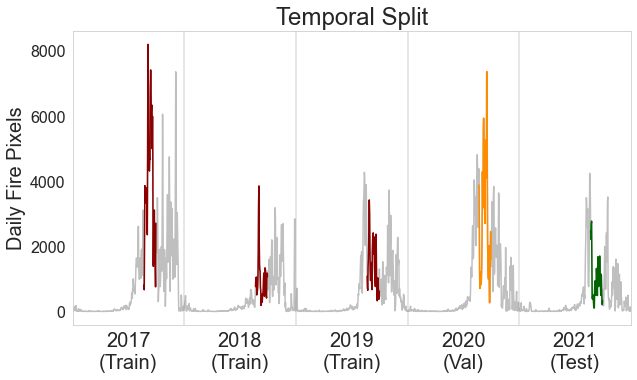

In [16]:
sns.set_style('whitegrid', {'axes.grid' : False})
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.xlim(px_combined['Date'].min(),px_combined['Date'].max())
px_combined.groupby('Date')['Date'].count().plot.line(ax=ax, color='grey', alpha=.5)

px_combined[(px_combined['Date'] > '8/21/2017') &
            (px_combined['Date'] < '10/1/2017')].groupby('Date')['Date'].count().plot.line(ax=ax, color='darkred')
px_combined[(px_combined['Date'] > '8/21/2018') &
            (px_combined['Date'] < '10/1/2018')].groupby('Date')['Date'].count().plot.line(ax=ax, color='darkred')
px_combined[(px_combined['Date'] > '8/21/2019') &
            (px_combined['Date'] < '10/1/2019')].groupby('Date')['Date'].count().plot.line(ax=ax, color='darkred')
px_combined[(px_combined['Date'] > '8/21/2020') &
            (px_combined['Date'] < '10/1/2020')].groupby('Date')['Date'].count().plot.line(ax=ax, color='darkorange')
px_combined[(px_combined['Date'] > '8/21/2021') &
            (px_combined['Date'] < '10/1/2021')].groupby('Date')['Date'].count().plot.line(ax=ax, color='darkgreen')


plt.xticks(['7/2/17','7/2/18','7/2/19','7/2/20','7/2/21'], 
           ('2017\n(Train)', '2018\n(Train)', '2019\n(Train)', '2020\n(Val)', '2021\n(Test)'), 
           rotation=0, fontsize=20, horizontalalignment='center')
plt.xlabel('')
plt.axvline(x='1/1/2018',color='grey', alpha=0.25)
plt.axvline(x='1/1/2019',color='grey', alpha=0.25)
plt.axvline(x='1/1/2020',color='grey', alpha=0.25)
plt.axvline(x='1/1/2021',color='grey', alpha=0.25)
plt.ylabel('Daily Fire Pixels', fontsize=20)
plt.yticks(fontsize=16)
plt.title('Temporal Split', fontsize=24)

In [87]:
px_combined[px_combined['Date'] == '9/1/2019'][['Lat','Lon','Date']]

,Lat,Lon,Date
609153,-2.291467,-48.040363,2019-09-01
609154,-2.292312,-48.035187,2019-09-01
609155,-2.296235,-48.041172,2019-09-01
609156,-2.297082,-48.035969,2019-09-01
609157,-2.301848,-48.036770,2019-09-01
...,...,...,...
610413,1.395458,-56.074070,2019-09-01
610414,1.489804,-55.820248,2019-09-01
610415,1.901110,-55.841251,2019-09-01
610416,2.280039,-55.860748,2019-09-01


In [90]:
defo_gpd[['image_date','geometry','x_min','x_max','y_min','y_max']]

,image_date,geometry,x_min,x_max,y_min,y_max
55,2016-07-26,"POLYGON ((-49.82841 -5.65815, -49.82841 -5.657...",-49.828405,-49.827160,-5.658776,-5.657032
60,2010-10-10,"POLYGON ((-55.80007 -2.98372, -55.80007 -2.983...",-55.800070,-55.799906,-2.983719,-2.983713
66,2009-08-08,"POLYGON ((-49.75312 -5.65300, -49.75312 -5.652...",-49.753124,-49.750000,-5.653538,-5.651117
118,2010-07-26,"POLYGON ((-49.75000 -5.72025, -49.75000 -5.718...",-49.750000,-49.747475,-5.720250,-5.717566
126,2015-08-14,"POLYGON ((-54.64673 -2.97552, -54.64671 -2.975...",-54.646727,-54.646610,-2.975918,-2.975517
...,...,...,...,...,...,...
599801,2014-08-20 12:00:00,"POLYGON ((-52.40190 -3.50020, -52.40030 -3.500...",-52.404588,-52.399477,-3.502082,-3.500199
599802,2014-08-20 12:00:00,"POLYGON ((-52.23942 -3.51419, -52.23835 -3.514...",-52.240229,-52.236194,-3.520643,-3.514187
599803,2017-07-27,"POLYGON ((-52.33761 -3.42106, -52.33669 -3.420...",-52.337607,-52.333170,-3.426145,-3.419639
599804,2010-07-24,"POLYGON ((-52.27818 -3.52979, -52.27818 -3.529...",-52.278446,-52.272797,-3.532211,-3.528176


In [87]:
wind_data[wind_data['date'] == pd.to_datetime('9/1/2019').date()]#[['lat','lon','date','U','V','Time_Hour']]

,index,Unnamed: 0,lat,lon,U,V,Time_Hour,date,wspd,wdir
40352256,10077696,0,-34.0,-73.750,1.083511,14.074376,0.0,2019-09-01,14.116021,4.402212
40352257,10077697,1,-33.5,-73.750,0.787612,14.004064,0.0,2019-09-01,14.026195,3.219021
40352258,10077698,2,-33.0,-73.750,0.565444,13.957189,0.0,2019-09-01,13.968638,2.319942
40352259,10077699,3,-32.5,-73.750,0.530288,13.859532,0.0,2019-09-01,13.869674,2.191161
40352260,10077700,4,-32.0,-73.750,0.593765,13.672032,0.0,2019-09-01,13.684919,2.486744
...,...,...,...,...,...,...,...,...,...,...
40393723,10119163,5179,4.0,-34.375,-2.875025,5.658893,21.0,2019-09-01,6.347349,-26.933039
40393724,10119164,5180,4.5,-34.375,-2.315302,6.028034,21.0,2019-09-01,6.457385,-21.011234
40393725,10119165,5181,5.0,-34.375,-1.623652,6.373737,21.0,2019-09-01,6.577292,-14.291613
40393726,10119166,5182,5.5,-34.375,-0.805292,6.572956,21.0,2019-09-01,6.622103,-6.984839


In [115]:
wdf_grouped.loc[pd.to_datetime('9/1/2019').date(),:,:]

U          V
date       lat   lon                         
2019-09-01 -34.0 -73.750  1.489112  14.116520
                 -73.125  2.576820  13.396306
                 -72.500  2.639686  11.782536
                 -71.875  2.043067   7.609685
                 -71.250  1.496940   3.206608
...                            ...        ...
            6.0  -36.875  0.275550   5.804020
                 -36.250  0.408263   6.025456
                 -35.625  0.561088   6.179020
                 -35.000  0.644828   6.360661
                 -34.375  0.719222   6.569890

[5184 rows x 2 columns]

In [46]:
# Adding year/month buckets.
px_combined['Year'] = px_combined['Date'].dt.year
px_combined['Month'] = px_combined['Date'].dt.month

Text(0.5, 1.0, 'Fire Pixels by Month')

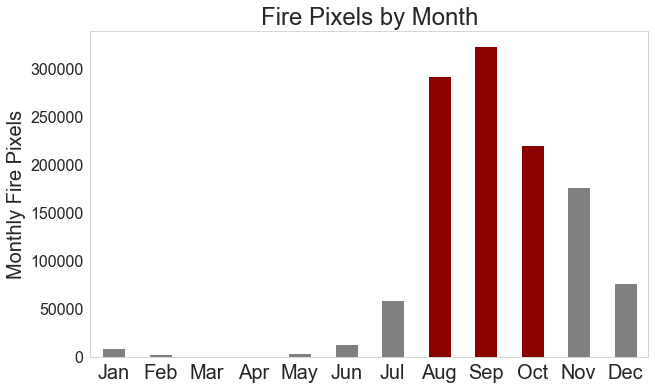

In [86]:
sns.set_style('whitegrid', {'axes.grid' : False})
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
px_combined.groupby('Month').count()['sat'].plot.bar(color=
        ['grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'darkred', 'darkred', 'darkred', 'grey', 'grey'])

plt.xticks([x for x in range(0,12)], 
           (['Jan', 'Feb' ,'Mar' ,'Apr' ,'May' , 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']), 
           rotation=0, fontsize=20, horizontalalignment='center')
plt.xlabel('')
plt.ylabel('Monthly Fire Pixels', fontsize=20)
plt.yticks(fontsize=16)
plt.title('Fire Pixels by Month', fontsize=24)

<AxesSubplot:xlabel='Year,Month'>

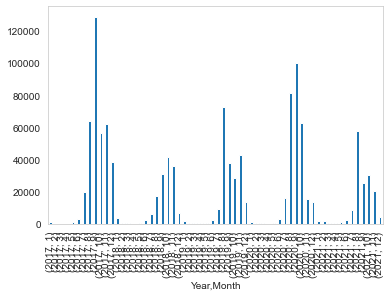

In [63]:
px_combined.groupby(['Year', 'Month']).count()['sat'].plot.bar()

Text(0.5, 1.0, 'Temporal Split (A)')

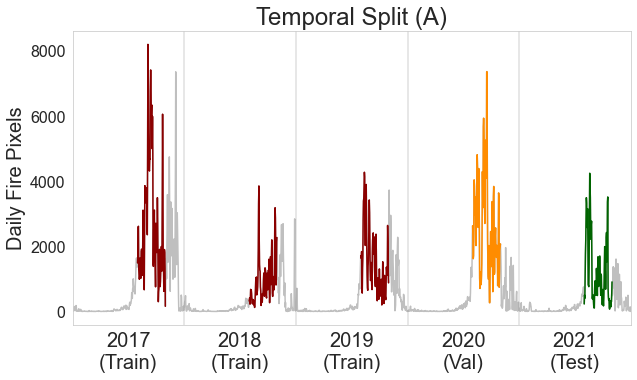

In [67]:
sns.set_style('whitegrid', {'axes.grid' : False})
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.xlim(px_combined['Date'].min(),px_combined['Date'].max())
px_combined.groupby('Date')['Date'].count().plot.line(ax=ax, color='grey', alpha=.5)

px_combined[(px_combined['Date'] > '7/31/2017') &
            (px_combined['Date'] < '11/1/2017')].groupby('Date')['Date'].count().plot.line(ax=ax, color='darkred')
px_combined[(px_combined['Date'] > '7/31/2018') &
            (px_combined['Date'] < '11/1/2018')].groupby('Date')['Date'].count().plot.line(ax=ax, color='darkred')
px_combined[(px_combined['Date'] > '7/31/2019') &
            (px_combined['Date'] < '11/1/2019')].groupby('Date')['Date'].count().plot.line(ax=ax, color='darkred')
px_combined[(px_combined['Date'] > '7/31/2020') &
            (px_combined['Date'] < '11/1/2020')].groupby('Date')['Date'].count().plot.line(ax=ax, color='darkorange')
px_combined[(px_combined['Date'] > '7/31/2021') &
            (px_combined['Date'] < '11/1/2021')].groupby('Date')['Date'].count().plot.line(ax=ax, color='darkgreen')


plt.xticks(['7/2/17','7/2/18','7/2/19','7/2/20','7/2/21'], 
           ('2017\n(Train)', '2018\n(Train)', '2019\n(Train)', '2020\n(Val)', '2021\n(Test)'), 
           rotation=0, fontsize=20, horizontalalignment='center')
plt.xlabel('')
plt.axvline(x='1/1/2018',color='grey', alpha=0.25)
plt.axvline(x='1/1/2019',color='grey', alpha=0.25)
plt.axvline(x='1/1/2020',color='grey', alpha=0.25)
plt.axvline(x='1/1/2021',color='grey', alpha=0.25)
plt.ylabel('Daily Fire Pixels', fontsize=20)
plt.yticks(fontsize=16)
plt.title('Temporal Split (A)', fontsize=24)

Text(0.5, 1.0, 'Temporal Split (B)')

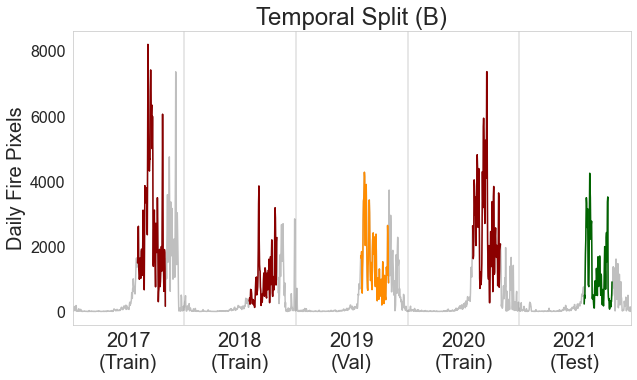

In [68]:
sns.set_style('whitegrid', {'axes.grid' : False})
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.xlim(px_combined['Date'].min(),px_combined['Date'].max())
px_combined.groupby('Date')['Date'].count().plot.line(ax=ax, color='grey', alpha=.5)

px_combined[(px_combined['Date'] > '7/31/2017') &
            (px_combined['Date'] < '11/1/2017')].groupby('Date')['Date'].count().plot.line(ax=ax, color='darkred')
px_combined[(px_combined['Date'] > '7/31/2018') &
            (px_combined['Date'] < '11/1/2018')].groupby('Date')['Date'].count().plot.line(ax=ax, color='darkred')
px_combined[(px_combined['Date'] > '7/31/2019') &
            (px_combined['Date'] < '11/1/2019')].groupby('Date')['Date'].count().plot.line(ax=ax, color='darkorange')
px_combined[(px_combined['Date'] > '7/31/2020') &
            (px_combined['Date'] < '11/1/2020')].groupby('Date')['Date'].count().plot.line(ax=ax, color='darkred')
px_combined[(px_combined['Date'] > '7/31/2021') &
            (px_combined['Date'] < '11/1/2021')].groupby('Date')['Date'].count().plot.line(ax=ax, color='darkgreen')


plt.xticks(['7/2/17','7/2/18','7/2/19','7/2/20','7/2/21'], 
           ('2017\n(Train)', '2018\n(Train)', '2019\n(Val)', '2020\n(Train)', '2021\n(Test)'), 
           rotation=0, fontsize=20, horizontalalignment='center')
plt.xlabel('')
plt.axvline(x='1/1/2018',color='grey', alpha=0.25)
plt.axvline(x='1/1/2019',color='grey', alpha=0.25)
plt.axvline(x='1/1/2020',color='grey', alpha=0.25)
plt.axvline(x='1/1/2021',color='grey', alpha=0.25)
plt.ylabel('Daily Fire Pixels', fontsize=20)
plt.yticks(fontsize=16)
plt.title('Temporal Split (B)', fontsize=24)

Text(0.5, 1.0, 'Temporal Split (C)')

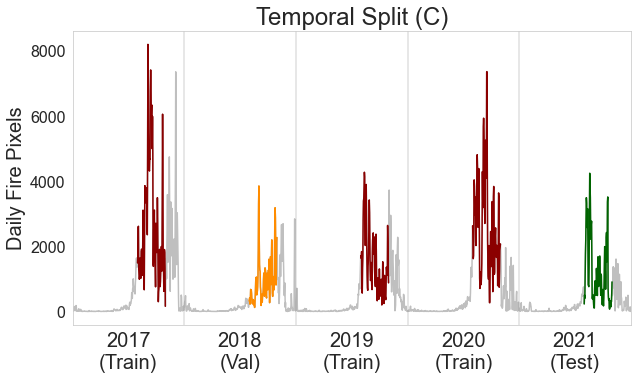

In [69]:
sns.set_style('whitegrid', {'axes.grid' : False})
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.xlim(px_combined['Date'].min(),px_combined['Date'].max())
px_combined.groupby('Date')['Date'].count().plot.line(ax=ax, color='grey', alpha=.5)

px_combined[(px_combined['Date'] > '7/31/2017') &
            (px_combined['Date'] < '11/1/2017')].groupby('Date')['Date'].count().plot.line(ax=ax, color='darkred')
px_combined[(px_combined['Date'] > '7/31/2018') &
            (px_combined['Date'] < '11/1/2018')].groupby('Date')['Date'].count().plot.line(ax=ax, color='darkorange')
px_combined[(px_combined['Date'] > '7/31/2019') &
            (px_combined['Date'] < '11/1/2019')].groupby('Date')['Date'].count().plot.line(ax=ax, color='darkred')
px_combined[(px_combined['Date'] > '7/31/2020') &
            (px_combined['Date'] < '11/1/2020')].groupby('Date')['Date'].count().plot.line(ax=ax, color='darkred')
px_combined[(px_combined['Date'] > '7/31/2021') &
            (px_combined['Date'] < '11/1/2021')].groupby('Date')['Date'].count().plot.line(ax=ax, color='darkgreen')


plt.xticks(['7/2/17','7/2/18','7/2/19','7/2/20','7/2/21'], 
           ('2017\n(Train)', '2018\n(Val)', '2019\n(Train)', '2020\n(Train)', '2021\n(Test)'), 
           rotation=0, fontsize=20, horizontalalignment='center')
plt.xlabel('')
plt.axvline(x='1/1/2018',color='grey', alpha=0.25)
plt.axvline(x='1/1/2019',color='grey', alpha=0.25)
plt.axvline(x='1/1/2020',color='grey', alpha=0.25)
plt.axvline(x='1/1/2021',color='grey', alpha=0.25)
plt.ylabel('Daily Fire Pixels', fontsize=20)
plt.yticks(fontsize=16)
plt.title('Temporal Split (C)', fontsize=24)

Text(0.5, 1.0, 'Temporal Split (D)')

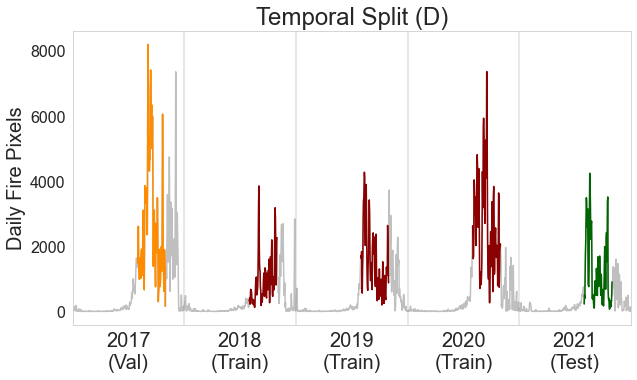

In [70]:
sns.set_style('whitegrid', {'axes.grid' : False})
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.xlim(px_combined['Date'].min(),px_combined['Date'].max())
px_combined.groupby('Date')['Date'].count().plot.line(ax=ax, color='grey', alpha=.5)

px_combined[(px_combined['Date'] > '7/31/2017') &
            (px_combined['Date'] < '11/1/2017')].groupby('Date')['Date'].count().plot.line(ax=ax, color='darkorange')
px_combined[(px_combined['Date'] > '7/31/2018') &
            (px_combined['Date'] < '11/1/2018')].groupby('Date')['Date'].count().plot.line(ax=ax, color='darkred')
px_combined[(px_combined['Date'] > '7/31/2019') &
            (px_combined['Date'] < '11/1/2019')].groupby('Date')['Date'].count().plot.line(ax=ax, color='darkred')
px_combined[(px_combined['Date'] > '7/31/2020') &
            (px_combined['Date'] < '11/1/2020')].groupby('Date')['Date'].count().plot.line(ax=ax, color='darkred')
px_combined[(px_combined['Date'] > '7/31/2021') &
            (px_combined['Date'] < '11/1/2021')].groupby('Date')['Date'].count().plot.line(ax=ax, color='darkgreen')


plt.xticks(['7/2/17','7/2/18','7/2/19','7/2/20','7/2/21'], 
           ('2017\n(Val)', '2018\n(Train)', '2019\n(Train)', '2020\n(Train)', '2021\n(Test)'), 
           rotation=0, fontsize=20, horizontalalignment='center')
plt.xlabel('')
plt.axvline(x='1/1/2018',color='grey', alpha=0.25)
plt.axvline(x='1/1/2019',color='grey', alpha=0.25)
plt.axvline(x='1/1/2020',color='grey', alpha=0.25)
plt.axvline(x='1/1/2021',color='grey', alpha=0.25)
plt.ylabel('Daily Fire Pixels', fontsize=20)
plt.yticks(fontsize=16)
plt.title('Temporal Split (D)', fontsize=24)

### Final Presentation Viz

Text(0.5, 1.0, '4-Fold Temporal Split')

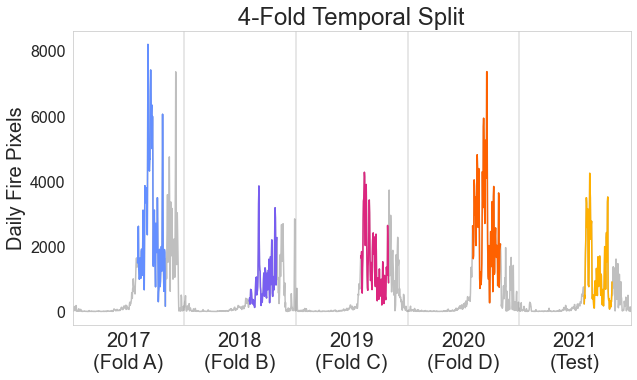

In [22]:
sns.set_style('whitegrid', {'axes.grid' : False})
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.xlim(px_combined['Date'].min(),px_combined['Date'].max())
px_combined.groupby('Date')['Date'].count().plot.line(ax=ax, color='grey', alpha=.5)

px_combined[(px_combined['Date'] > '7/31/2017') &
            (px_combined['Date'] < '11/1/2017')].groupby('Date')['Date'].count().plot.line(ax=ax, color='#648FFF')
px_combined[(px_combined['Date'] > '7/31/2018') &
            (px_combined['Date'] < '11/1/2018')].groupby('Date')['Date'].count().plot.line(ax=ax, color='#785EF0')
px_combined[(px_combined['Date'] > '7/31/2019') &
            (px_combined['Date'] < '11/1/2019')].groupby('Date')['Date'].count().plot.line(ax=ax, color='#DC267F')
px_combined[(px_combined['Date'] > '7/31/2020') &
            (px_combined['Date'] < '11/1/2020')].groupby('Date')['Date'].count().plot.line(ax=ax, color='#FE6100')
px_combined[(px_combined['Date'] > '7/31/2021') &
            (px_combined['Date'] < '11/1/2021')].groupby('Date')['Date'].count().plot.line(ax=ax, color='#FFB000')


plt.xticks(['7/2/17','7/2/18','7/2/19','7/2/20','7/2/21'], 
           ('2017\n(Fold A)', '2018\n(Fold B)', '2019\n(Fold C)', '2020\n(Fold D)', '2021\n(Test)'), 
           rotation=0, fontsize=20, horizontalalignment='center')
plt.xlabel('')
plt.axvline(x='1/1/2018',color='grey', alpha=0.25)
plt.axvline(x='1/1/2019',color='grey', alpha=0.25)
plt.axvline(x='1/1/2020',color='grey', alpha=0.25)
plt.axvline(x='1/1/2021',color='grey', alpha=0.25)
plt.ylabel('Daily Fire Pixels', fontsize=20)
plt.yticks(fontsize=16)
plt.title('4-Fold Temporal Split', fontsize=24)

target 0.33/16 0.33783435821533203 15.940406799316406


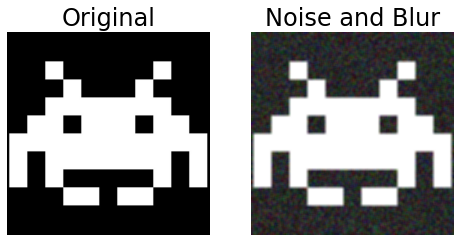

In [18]:
invader = 255 - cv2.imread('invader.jpg')
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ssims, psnrs = [],[]

ax[0].imshow(invader)
ax[0].set_title('Original')
ax[0].axis("off")

# Blurry version.
gauss = np.random.normal(0,1,invader.size)
gauss = gauss.reshape(invader.shape[0],invader.shape[1],invader.shape[2]).astype('uint8')
invader_both = cv2.add(invader, gauss)
invader_both = cv2.blur(invader_both, (10, 10))
ax[1].imshow(invader_both)
ax[1].set_title('Noise and Blur')
ax[1].axis("off")
ssims.append(tf.image.ssim(invader, invader_both, 255))
psnrs.append(tf.image.psnr(invader, invader_both, 255))

'''
# Noisy Version.
gauss = np.random.normal(0,1,invader.size)
gauss = gauss.reshape(invader.shape[0],invader.shape[1],invader.shape[2]).astype('uint8')
invader_gauss = cv2.add(invader,gauss)
ax[2].imshow(invader_gauss)
ax[2].set_title('With Noise')
ax[2].axis("off")
ssims.append(tf.image.ssim(invader, invader_gauss, 255))
psnrs.append(tf.image.psnr(invader, invader_gauss, 255))

# Double transformed.
gauss = np.random.normal(0,1,invader.size)
gauss = gauss.reshape(invader.shape[0],invader.shape[1],invader.shape[2]).astype('uint8')
invader_both = cv2.add(invader_blur, gauss)
ax[3].imshow(invader_both)
ax[3].set_title('With Blur and Noise')
ax[3].axis("off")
ssims.append(tf.image.ssim(invader, invader_both, 255))
psnrs.append(tf.image.psnr(invader, invader_both, 255))
'''

for x in range(0,2):
    ax[x].title.set_fontsize(24)

print('target 0.33/16',float(ssims[0]), float(psnrs[0]))

[0.4126593768596649, 0.7790306806564331, 0.34446707367897034] [11.459648132324219, 9.923741340637207, 10.464944839477539]


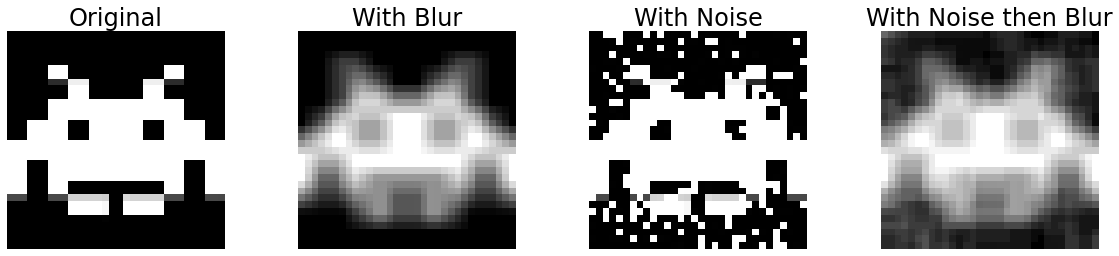

In [70]:
invader = 255 - cv2.imread('invader.jpg')
invader = cv2.resize(invader, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
invader = np.expand_dims(cv2.cvtColor(invader, cv2.COLOR_BGR2GRAY), axis = -1)

fig, ax = plt.subplots(1, 4, figsize=(20, 4))
ssims, psnrs = [],[]

ax[0].imshow(invader, cmap = 'gray')
ax[0].set_title('Original')
ax[0].axis("off")

# Blurry version.
invader_blur = np.expand_dims(cv2.blur(invader, (5, 5)), axis = -1)
ax[1].imshow(invader_blur, cmap = 'gray')
ax[1].set_title('With Blur')
ax[1].axis("off")
ssims.append(tf.image.ssim(invader, invader_blur, 255))
psnrs.append(tf.image.psnr(invader, invader_blur, 255))

# Noisy Version.
gauss = np.random.normal(0,1,invader.size)
gauss = gauss.reshape(invader.shape[0],invader.shape[1],invader.shape[2]).astype('uint8')
invader_gauss = np.expand_dims(cv2.add(invader,gauss), axis = -1)
ax[2].imshow(invader_gauss, cmap = 'gray')
ax[2].set_title('With Noise')
ax[2].axis("off")
ssims.append(tf.image.ssim(invader, invader_gauss, 255))
psnrs.append(tf.image.psnr(invader, invader_gauss, 255))

# Double transformed.
gauss = np.random.normal(0,1,invader.size)
gauss = gauss.reshape(invader.shape[0],invader.shape[1],invader.shape[2]).astype('uint8')
invader_both = np.expand_dims(cv2.add(invader, gauss), axis = -1)
invader_both = np.expand_dims(cv2.blur(invader_both, (5, 5)), axis = -1)
ax[3].imshow(invader_both, cmap = 'gray')
ax[3].set_title('With Noise then Blur')
ax[3].axis("off")
ssims.append(tf.image.ssim(invader, invader_both, 255))
psnrs.append(tf.image.psnr(invader, invader_both, 255))

for x in range(0,4):
    ax[x].title.set_fontsize(24)

print([float(x) for x in ssims], [float(x) for x in psnrs])

target 0.33/16 0.3732597529888153 10.988574981689453


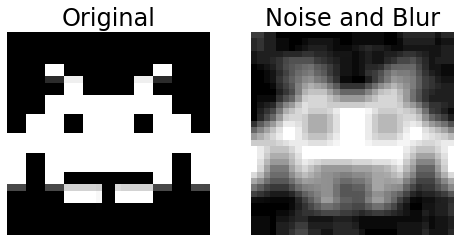

In [155]:
invader = 255 - cv2.imread('invader.jpg')
invader = cv2.resize(invader, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
invader = np.expand_dims(cv2.cvtColor(invader, cv2.COLOR_BGR2GRAY), axis = -1)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ssims, psnrs = [],[]

ax[0].imshow(invader, cmap = 'gray')
ax[0].set_title('Original')
ax[0].axis("off")

# Blurry version.
gauss = np.random.normal(0,1,invader.size) / 1.5
gauss = gauss.reshape(invader.shape[0],invader.shape[1],invader.shape[2]).astype('uint8')
invader_both = cv2.add(invader, gauss)
invader_both = np.expand_dims(cv2.blur(invader_both, (5, 5)), axis = -1)
ax[1].imshow(invader_both, cmap = 'gray')
ax[1].set_title('Noise and Blur')
ax[1].axis("off")
ssims.append(tf.image.ssim(invader, invader_both, 255))
psnrs.append(tf.image.psnr(invader, invader_both, 255))

for x in range(0,2):
    ax[x].title.set_fontsize(24)

print('target 0.33/16',float(ssims[0]), float(psnrs[0]))

target 0.75/45 0.7376732230186462 13.31336784362793


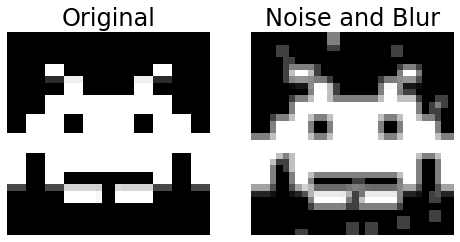

In [176]:
invader = 255 - cv2.imread('invader.jpg')
invader = cv2.resize(invader, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
invader = np.expand_dims(cv2.cvtColor(invader, cv2.COLOR_BGR2GRAY), axis = -1)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ssims, psnrs = [],[]

ax[0].imshow(invader, cmap = 'gray')
ax[0].set_title('Original')
ax[0].axis("off")

# Blurry version.
gauss = np.random.normal(0,1,invader.size) * 0.5
gauss = gauss.reshape(invader.shape[0],invader.shape[1],invader.shape[2]).astype('uint8')
invader_both = cv2.add(invader, gauss)
invader_both = np.expand_dims(cv2.blur(invader_both, (2, 2)), axis = -1)
ax[1].imshow(invader_both, cmap = 'gray')
ax[1].set_title('Noise and Blur')
ax[1].axis("off")
ssims.append(tf.image.ssim(invader, invader_both, 255))
psnrs.append(tf.image.psnr(invader, invader_both, 255))

for x in range(0,2):
    ax[x].title.set_fontsize(24)

print('target 0.75/45',float(ssims[0]), float(psnrs[0]))

target 0.75/45 0.7492002248764038 13.78463077545166


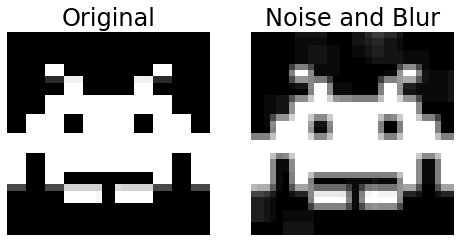

In [199]:
invader = 255 - cv2.imread('invader.jpg')
invader = cv2.resize(invader, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
invader = np.expand_dims(cv2.cvtColor(invader, cv2.COLOR_BGR2GRAY), axis = -1)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ssims, psnrs = [],[]

ax[0].imshow(invader, cmap = 'gray')
ax[0].set_title('Original')
ax[0].axis("off")

# Blurry version.
gauss = np.random.normal(0,1,invader.size) * 0.5
gauss = gauss.reshape(invader.shape[0],invader.shape[1],invader.shape[2]).astype('uint8')
gauss = cv2.blur(gauss, (5,5))
invader_both = np.expand_dims(cv2.blur(invader, (2, 2)), axis = -1)
invader_both = np.expand_dims(cv2.add(invader_both, gauss), axis = -1)
ax[1].imshow(invader_both, cmap = 'gray')
ax[1].set_title('Noise and Blur')
ax[1].axis("off")
ssims.append(tf.image.ssim(invader, invader_both, 255))
psnrs.append(tf.image.psnr(invader, invader_both, 255))

for x in range(0,2):
    ax[x].title.set_fontsize(24)

print('target 0.75/45',float(ssims[0]), float(psnrs[0]))